<a href="https://colab.research.google.com/github/Manasi758/Tcs-ion-Rio-125--Forecasting-Retail-Demand/blob/main/Time_series_of_office_supplies_versus_furniture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import libraries
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
import matplotlib

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

import warnings
warnings.filterwarnings('ignore')





# Importing Dataset

In [ ]:
sales=pd.read_csv("C:/Users/Delll/Downloads/train.csv")

In [ ]:
sales.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08-11-2017,11-11-2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08-11-2017,11-11-2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12-06-2017,16-06-2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11-10-2016,18-10-2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11-10-2016,18-10-2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


# Time Series of Office Supplies vs. Furniture
According to our data, the size of Office Supplies is much larger than the size of Furniture.



In [ ]:


furniture = sales.loc[sales['Category'] == 'Furniture']
furniture = furniture[['Order Date', 'Sales']]
furniture = furniture.sort_values('Order Date')
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
furniture = furniture.set_index('Order Date')
furniture.head()

,Sales
Order Date,
2015-01-03,1893.995
2015-01-06,2024.060
2015-01-08,44.128
2015-01-11,31.680
2015-01-12,4513.606


In [ ]:
monthly_office = monthly
monthly_furniture = furniture['Sales'].resample('MS').mean()
furniture = pd.DataFrame({'Order Date':monthly_furniture.index, 'Sales':monthly_furniture.values})
office = pd.DataFrame({'Order Date': monthly_office.index, 'Sales': monthly_office.values})

store = furniture.merge(office, how = 'inner', on = 'Order Date')
store.rename(columns = {'Sales_x': 'furniture_sales', 'Sales_y': 'office_sales'}, inplace=True)
store.head()

,Order Date,furniture_sales,office_sales
0,2015-01-01,924.024462,442.918737
1,2015-02-01,248.475714,218.343909
2,2015-03-01,778.884778,302.427250
3,2015-04-01,525.167692,352.387750
4,2015-05-01,390.457467,698.627304


# Visualizing the Sales Data¶


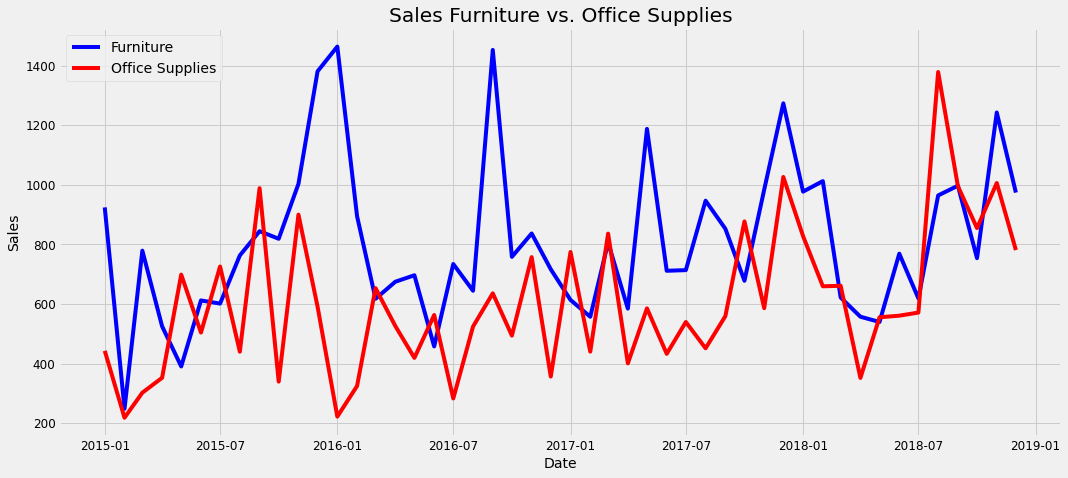

In [ ]:
plt.figure(figsize = (16, 7))
plt.plot(store['Order Date'], store['furniture_sales'], 'b-', label = 'Furniture')
plt.plot(store['Order Date'], store['office_sales'], 'r-', label = 'Office Supplies')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Furniture vs. Office Supplies')
plt.legend()
plt.show()

# Time Series Modeling with Prophet
Prophet is designed for analyzing time-series that display patterns on different time scales such as yearly, weekly and daily. It also has advanced capabilities for modeling the effects of holidays on a time-series and implementing custom changepoints. Therefore, we are using Prophet to get a model up and running.

Let's take look at the Prophet forcasting models for Furniture and Office Supplies Sales.

19:31:57 - cmdstanpy - INFO - Chain [1] start processing
19:31:57 - cmdstanpy - INFO - Chain [1] done processing
19:31:57 - cmdstanpy - INFO - Chain [1] start processing
19:31:58 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1152x504 with 0 Axes>

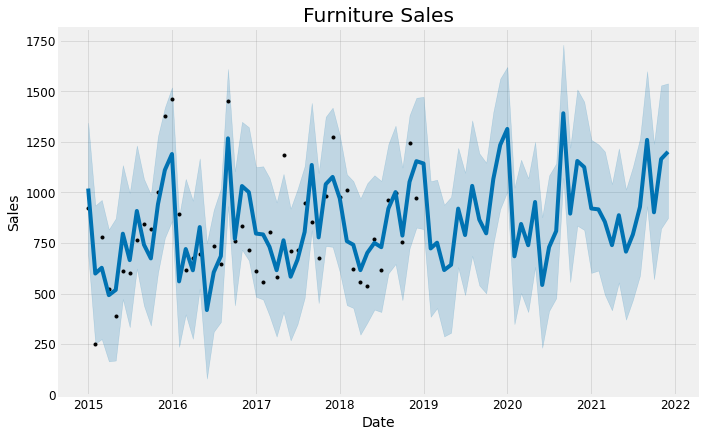

In [ ]:
from prophet import Prophet
furniture = furniture.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
furniture_model = Prophet(interval_width = 0.95)
furniture_model.fit(furniture)

office = office.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
office_model = Prophet(interval_width=0.95)
office_model.fit(office)

furniture_forecast = furniture_model.make_future_dataframe(periods = 36, freq = 'MS')
furniture_forecast = furniture_model.predict(furniture_forecast)

office_forecast = office_model.make_future_dataframe(periods = 36, freq = 'MS')
office_forecast = office_model.predict(office_forecast)

plt.figure(figsize = (16,7))
furniture_model.plot(furniture_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Furniture Sales')
plt.show()

<Figure size 1152x504 with 0 Axes>

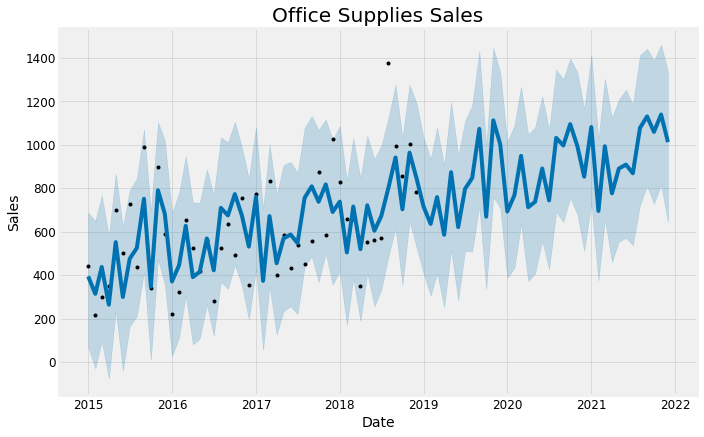

In [ ]:
plt.figure(figsize = (16,7))
office_model.plot(office_forecast, xlabel = 'Date', ylabel = 'Sales')

plt.title('Office Supplies Sales')
plt.show()

# Compare the Two Forecasts
We already have the forecasts for three years for these two categories into the future. We will now join them together to compare their future forecasts.

In [ ]:
furniture_names = ['furniture_%s' % column for column in furniture_forecast.columns]
office_names = ['office_%s' % column for column in office_forecast.columns]

merge_furniture_forecast = furniture_forecast.copy()
merge_office_forecast = office_forecast.copy()

merge_furniture_forecast.columns = furniture_names
merge_office_forecast.columns = office_names

forecast = pd.merge(merge_furniture_forecast, merge_office_forecast,
                   how = 'inner', left_on = 'furniture_ds',
                   right_on = 'office_ds')

forecast = forecast.rename(columns = {'furniture_ds': 'Date'}).drop('office_ds', axis = 1)

forecast.head()


,Date,furniture_trend,furniture_yhat_lower,furniture_yhat_upper,furniture_trend_lower,furniture_trend_upper,furniture_additive_terms,furniture_additive_terms_lower,furniture_additive_terms_upper,furniture_yearly,furniture_yearly_lower,furniture_yearly_upper,furniture_multiplicative_terms,furniture_multiplicative_terms_lower,furniture_multiplicative_terms_upper,furniture_yhat,office_trend,office_yhat_lower,office_yhat_upper,office_trend_lower,office_trend_upper,office_additive_terms,office_additive_terms_lower,office_additive_terms_upper,office_yearly,office_yearly_lower,office_yearly_upper,office_multiplicative_terms,office_multiplicative_terms_lower,office_multiplicative_terms_upper,office_yhat
0,2015-01-01,736.965966,691.770480,1345.002146,736.965966,736.965966,282.567670,282.567670,282.567670,282.567670,282.567670,282.567670,0.0,0.0,0.0,1019.533636,457.756163,69.503453,688.696599,457.756163,457.756163,-62.931792,-62.931792,-62.931792,-62.931792,-62.931792,-62.931792,0.0,0.0,0.0,394.824370
1,2015-02-01,739.599541,252.041757,935.710345,739.599541,739.599541,-140.378066,-140.378066,-140.378066,-140.378066,-140.378066,-140.378066,0.0,0.0,0.0,599.221475,464.580145,-28.103746,650.096197,464.580145,464.580145,-149.844740,-149.844740,-149.844740,-149.844740,-149.844740,-149.844740,0.0,0.0,0.0,314.735404
2,2015-03-01,741.978254,275.357676,963.087783,741.978254,741.978254,-114.272731,-114.272731,-114.272731,-114.272731,-114.272731,-114.272731,0.0,0.0,0.0,627.705524,470.743741,96.307583,767.569658,470.743741,470.743741,-32.489595,-32.489595,-32.489595,-32.489595,-32.489595,-32.489595,0.0,0.0,0.0,438.254146
3,2015-04-01,744.611830,165.203469,817.271921,744.611830,744.611830,-252.357755,-252.357755,-252.357755,-252.357755,-252.357755,-252.357755,0.0,0.0,0.0,492.254074,477.567723,-75.282883,579.290847,477.567723,477.567723,-212.724187,-212.724187,-212.724187,-212.724187,-212.724187,-212.724187,0.0,0.0,0.0,264.843535
4,2015-05-01,747.160451,169.009445,871.832852,747.160451,747.160451,-228.882749,-228.882749,-228.882749,-228.882749,-228.882749,-228.882749,0.0,0.0,0.0,518.277702,484.171576,239.033877,868.206759,484.171576,484.171576,68.541160,68.541160,68.541160,68.541160,68.541160,68.541160,0.0,0.0,0.0,552.712736


# Trend and Forecast Visualization¶


No handles with labels found to put in legend.


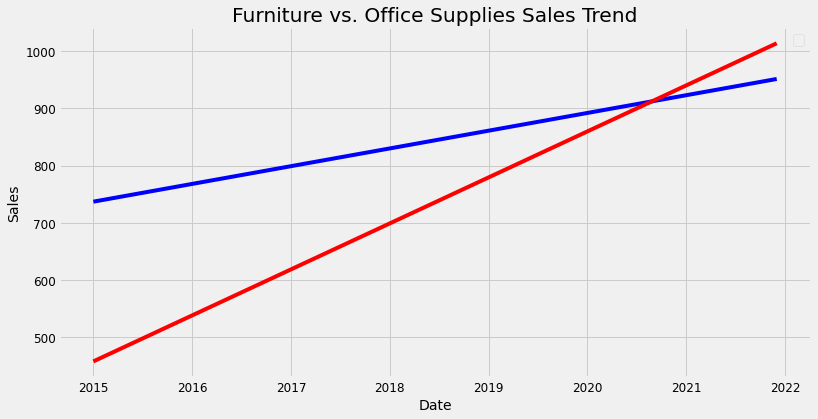

In [ ]:
plt.figure(figsize = (12, 6))
plt.plot(forecast['Date'], forecast['furniture_trend'],'b-')
plt.plot(forecast['Date'], forecast['office_trend'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Sales Trend');
plt.show()


No handles with labels found to put in legend.


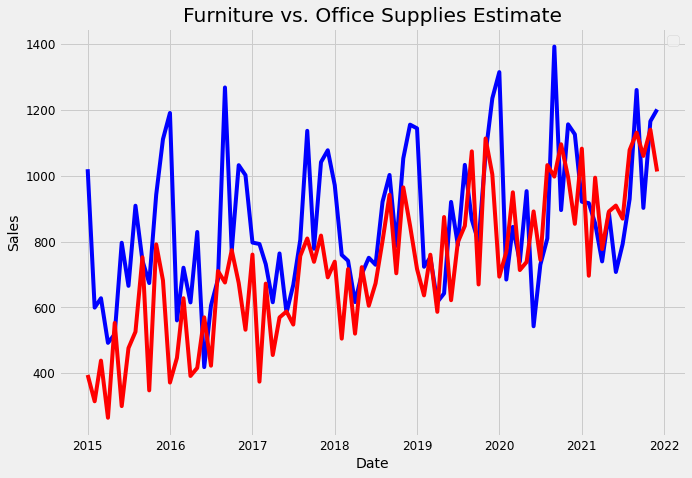

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['furniture_yhat'], 'b-')
plt.plot(forecast['Date'], forecast['office_yhat'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Estimate');

# Trends and Patterns
Now, we can use the Prophet Models to inspect different trends of these two categories in the data.

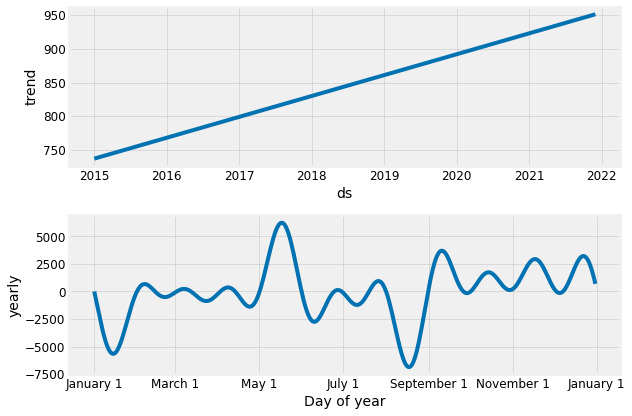

In [ ]:
furniture_model.plot_components(furniture_forecast)
plt.show()


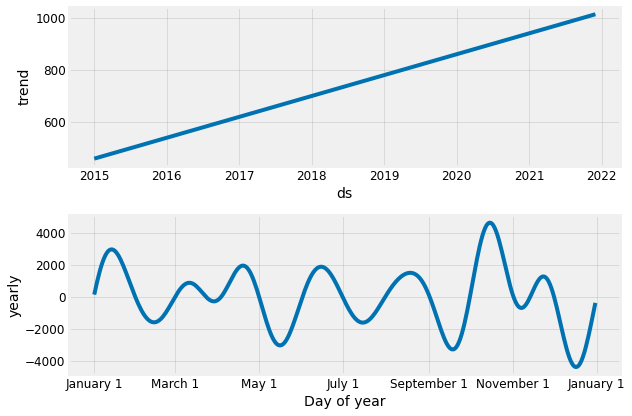

In [ ]:
office_model.plot_components(office_forecast)
plt.show()

Good to see that the sales for both furniture and office supplies have been linearly increasing over time and will be keep growing, although office supplies’ growth seems slightly stronger.